In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_california_housing
import torch
import model as md
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import tqdm
import torch_intermediate_layer_getter as ilg
from model import MLP

In [2]:
california_housing = fetch_california_housing(as_frame=True)
X = california_housing.data.loc[:, ['HouseAge', 'AveRooms', 'AveBedrms', 'Population',
                                     'AveOccup', 'Latitude', 'Longitude']]
Y = pd.concat([california_housing.target, california_housing.data.loc[:, 'MedInc']], axis = 1)

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.6, random_state=42)
X_calib, X_test, Y_calib, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)
X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
Y_train = torch.tensor(Y_train.values, dtype=torch.float32)
Y_test = torch.tensor(Y_test.values, dtype=torch.float32)
X_calib = torch.tensor(X_calib.values, dtype=torch.float32)
Y_calib = torch.tensor(Y_calib.values, dtype=torch.float32)

In [4]:
torch.manual_seed(42)
train_loader = DataLoader(list(zip(X_train, Y_train)), batch_size=64, shuffle=True)
calib_loader = DataLoader(list(zip(X_calib, Y_calib)), batch_size=1, shuffle=True)
test_loader = DataLoader(list(zip(X_test, Y_test)), batch_size=1, shuffle=True)

In [5]:
lol = md.MLP([7, 64, 128, 64, 2])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lol = lol.to(device)
lr = 0.01
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, lol.parameters()), lr=lr, weight_decay = 0.0001)

In [6]:
def loss_fn_mse(y, y_hat):
    mse_loss = torch.nn.MSELoss()
    return mse_loss(y, y_hat)

In [7]:
def loss_fn_VAE(recon_feature, og_feature, means, log_var):
    mse_loss = torch.nn.MSELoss()
    mse = mse_loss(recon_feature, og_feature)
    kl_loss = -0.5 * torch.sum(1 + log_var - means.pow(2) - log_var.exp())
    return mse + kl_loss, mse, kl_loss

In [8]:
import torch
lol = torch.load("lol.pt")
cvae = torch.load("cvae.pt")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
def get_score_quantile(alpha, model, calib_loader):
    model.eval()
    with torch.no_grad():
        i = 0
        losses = []
        for data, target in calib_loader:
            data = data.to(device)
            target = target.to(device)
            i = i + 1
            Y_hat = model(data)
            loss = loss_fn_mse(Y_hat, target).cpu().numpy()
            losses.append(loss)
    N_c = len(calib_loader)
    return np.quantile(losses, (N_c + 1)*(1 - alpha)/N_c), np.sort(losses)

In [10]:
def get_variance_estimate(gen_model, model, calib_loader):
    gen_model.eval()
    with torch.no_grad():
        i = 0
        losses = np.zeros(64)
        for data, target in calib_loader:
            data = data.to(device)
            target = target.to(device)
            i = i + 1
            Z_hat = gen_model.generate(data, 1).to(device)
            Z = model.mlp[:-1](data)
            mse_loss = torch.nn.MSELoss(reduction='none')
            loss = torch.square(Z_hat - Z)
            losses = np.vstack((losses, loss.cpu().numpy()))
    return torch.tensor(np.sqrt(np.mean(losses[1:], axis = 0)), dtype = torch.float32)
    

In [11]:
score_quantile, loss = get_score_quantile(0.1, lol, calib_loader)
print(score_quantile)
print(loss)
print(torch.max(Y_train, dim = 0))

4.245632671270258
[1.0132837e-04 1.4889910e-04 1.9945085e-04 ... 3.4837074e+01 3.8332600e+01
 4.4323547e+01]
torch.return_types.max(
values=tensor([ 5.0000, 15.0001]),
indices=tensor([ 17, 167]))


In [12]:
variance_est = get_variance_estimate(cvae, lol, calib_loader)
print(variance_est)

tensor([4.0593e-01, 2.1543e-11, 1.3707e-06, 1.8020e-06, 2.4847e-08, 1.1839e-11,
        7.6108e-08, 8.8369e-10, 2.1050e-07, 2.8845e-03, 2.3023e-07, 1.0020e-02,
        1.1304e-07, 2.8555e-02, 1.4516e-05, 1.6765e-07, 3.2300e-06, 1.7817e-01,
        3.6100e-10, 2.8207e-06, 3.2829e-02, 3.7771e-02, 1.4877e-01, 9.3463e-06,
        3.0397e-12, 1.3561e-07, 2.6623e-06, 3.8958e-07, 1.0215e-07, 1.4126e-06,
        6.1932e-02, 1.2294e-01, 1.6362e-08, 1.9601e-03, 5.1450e-05, 2.7486e-01,
        6.4168e-02, 1.3775e-07, 3.3311e-11, 5.7322e-07, 2.4885e-05, 6.5393e-02,
        2.8680e-08, 2.9092e-05, 1.1030e-08, 1.5751e-01, 2.3125e-01, 5.2150e-09,
        1.2024e-10, 2.1277e-02, 4.4311e-13, 1.4285e-03, 1.9395e-09, 4.1996e-05,
        1.5824e-01, 1.4011e-12, 1.0123e-06, 4.1836e-08, 6.0674e-07, 2.4898e-01,
        1.7808e-09, 9.9885e-08, 2.9173e-10, 5.0318e-03])


In [13]:
def pp_csi(quantile, gen_model, point_estimator, n_samples, data, layer, var_est):
    gen_model.eval()
    point_estimator.eval()
    data = data.to(device)
    var_est = var_est.to(device)

    y_hat = point_estimator(data.reshape(1, -1))
    regen_w = gen_model.generate(data.reshape(1, -1), n_samples)
    noise = torch.randn(n_samples, regen_w.shape[1]).to(device)
    regen_z = regen_w + noise * var_est.repeat(n_samples, 1)
    regen_y = layer(regen_z)
    # regen_y = point_estimator(regen_w)
    prediction_set = y_hat.cpu().detach().numpy().reshape(1, -1)
    for i in range(n_samples):
        if loss_fn_mse(regen_y[i], y_hat) <= quantile:
            prediction_set = np.vstack((prediction_set, regen_y[i].cpu().detach().numpy().reshape(1, -1)))
    return prediction_set


In [14]:
# print(X_test[0].reshape(1, 7))
predictionset= pp_csi(score_quantile, cvae, lol, 200, X_test[0], lol.mlp[-1], variance_est)
# print(Y_train[0])
# print(predictionset)
# print(regen_w[0])
# print(lol.mlp[:-1](X_train[0].unsqueeze(0)))
# print(loss_fn_mse(regen_w[0], lol.mlp[:-1](X_train[0].unsqueeze(0))))
# print(loss_fn_mse(lol(X_train[0].unsqueeze(0)), lol.mlp[-1](regen_w[0])))
print(len(predictionset))

201


/home/yppatel/anaconda3/envs/chig/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Wow um this is trash and this is proof that something is sus

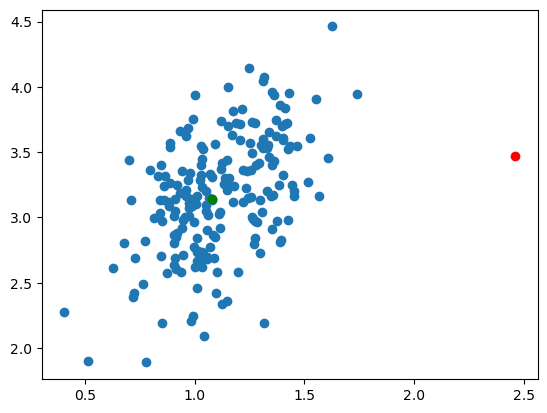

In [15]:
plot_x = predictionset[:, 0]
# plot_x = regen_y
plot_y = predictionset[:, 1]
plt.scatter(plot_x, plot_y)
plt.scatter(Y_test[0, 0].detach().numpy(), Y_test[0, 1].detach().numpy(), color = 'red')
plt.scatter(predictionset[0, 0], predictionset[0, 1], color = 'green')


In [18]:
def get_y_grid(min_y, max_y):
    y1 = np.linspace(min_y, max_y, 400)
    y2 = np.linspace(min_y, max_y, 400)
    y_unflat = np.meshgrid(y1, y2)
    return np.vstack((y_unflat[0].flatten(), y_unflat[1].flatten())).T.astype(np.float32)

In [19]:
min_y = -8
max_y = 8
y_grid = get_y_grid(min_y, max_y)

In [21]:
import time
import torch
import sbibm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import argparse

In [22]:
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [44]:
test_idx = np.random.randint(len(X_test))
X_test_pt = X_test[test_idx:test_idx+1]
Y_test_pt = Y_test[test_idx:test_idx+1]
Y_hat_test_pt = lol(X_test_pt.reshape(1, -1).to(device)).cpu().detach().numpy()

n_samples = 10
regen_w = cvae.generate(X_test_pt.reshape(1, -1).to(device), n_samples)
noise = torch.randn(n_samples, regen_w.shape[1]).to(device)
regen_z = regen_w + noise * variance_est.to(device).repeat(n_samples, 1)
regen_y = lol.mlp[-1](regen_z).cpu().detach().numpy()

In [45]:
scores = np.mean((y_grid - Y_hat_test_pt) ** 2, axis=1)
in_pred_region = scores < score_quantile
y_pred_region = y_grid[in_pred_region]

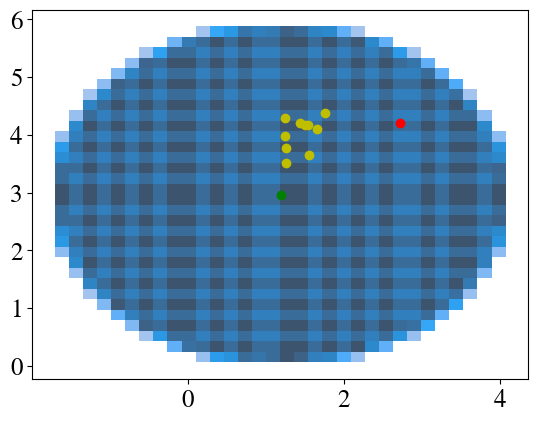

In [46]:
sns.histplot(x=y_pred_region[:,0], y=y_pred_region[:,1])
plt.scatter(Y_hat_test_pt[0,0], Y_hat_test_pt[0,1], c="g")
plt.scatter(Y_test_pt[0,0], Y_test_pt[0,1], c="r")
plt.scatter(regen_y[:,0], regen_y[:,1], c="y")